In [1]:
import jax
num_devices = jax.local_device_count()
print(f'# of GPUs : {num_devices}')

import haiku as hk
import optax
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from functools import partial
from itertools import product
from collections import OrderedDict

# we import some helper function/classes
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from models.resnet import ResNet, Block
from datasets.cifar import load_dataset

import matplotlib.pyplot as plt

# of GPUs : 8


/usr/local/lib/python3.8/dist-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
NUM_CLASSES = 100
NUM_EPOCH = 200
NUM_TRAIN = 50000
BATCH_SIZE = 1000
WARMUP_RATIO = 0.1
PEAK_LR = 0.4
batch_dims = (num_devices, BATCH_SIZE//num_devices)

rng = jax.random.PRNGKey(42)
batch = jnp.zeros((1, 32, 32, 3), jnp.float32)
net = partial(
    ResNet,
    name='ResNet_18',
    stage_sizes=[2, 2, 2, 2],
    num_filters=[64, 128, 256, 512],
    strides=[1, 2, 2, 2],
    block_cls=Block,
    num_classes=NUM_CLASSES,
)

net = make_forward_with_state(net)
params, state = net.init(rng, batch, train=True, print_shape=True)

tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.sgd(learning_rate=create_lr_sched(NUM_EPOCH, NUM_TRAIN, BATCH_SIZE, WARMUP_RATIO, PEAK_LR), momentum=0.9)
    )
trainer = Trainer.create(
    apply_fn=net.apply,
    params=params,
    state=state,
    tx=tx,
)

input : (1, 32, 32, 3)
embedding : (1, 32, 32, 64)
block_0_0 : (1, 32, 32, 64)
block_0_1 : (1, 32, 32, 64)
block_1_0 : (1, 16, 16, 128)
block_1_1 : (1, 16, 16, 128)
block_2_0 : (1, 8, 8, 256)
block_2_1 : (1, 8, 8, 256)
block_3_0 : (1, 4, 4, 512)
block_3_1 : (1, 4, 4, 512)
representation : (1, 512)
classifier head : (1, 100)


In [3]:
WD_COEF = 0.0

def loss_fn(params, trainer, batch, rng):
    # state contains batch statistics
    logit, state = trainer.apply_fn(params, trainer.state, rng, batch['x'], train=True)
    log_prob = jax.nn.log_softmax(logit)
    cross_entropy_loss = - (batch['y'] * log_prob).sum(axis=-1).mean()
    
    wd = (params_to_vec(params)**2).sum()
    
    loss = cross_entropy_loss + WD_COEF * wd
    acc = (jnp.argmax(logit, axis=-1) == jnp.argmax(batch['y'], axis=-1)).astype(int).mean()
    
    return loss, (cross_entropy_loss, wd, acc, state)

In [4]:
def opt_step(trainer, batch, rng):

  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, (loss, wd, acc, new_state) = grad_fn(
      trainer.params,
      trainer,
      batch,
      rng,
  )

  grad_norm = jnp.sqrt((params_to_vec(grads)**2).sum())
  
  grads = jax.lax.pmean(grads, axis_name='batch')
  new_state = jax.lax.pmean(new_state, axis_name='batch')
  trainer = trainer.apply_gradients(grads=grads, state=new_state)

  log = OrderedDict([
      ('loss', loss),
      ('wd', wd),
      ('acc', acc),
      ('grad_norm', grad_norm),
  ])
  log = jax.lax.pmean(log, axis_name='batch')

  return log, trainer

In [5]:
# opt_step_pmapped = jax.pmap(opt_step, axis_name='batch')
# trainer_replicated = replicate(trainer)

# train_dataset = load_dataset(NUM_CLASSES, batch_dims)
# test_dataset = list(load_dataset(NUM_CLASSES, batch_dims, False, False, False))

# for epoch in range(1, NUM_EPOCH+1):
    
#     pbar = tqdm(range(NUM_TRAIN // BATCH_SIZE))
#     for step in pbar:

#         batch = next(train_dataset)
#         rng, rng_ = jax.random.split(rng)
#         log, trainer_replicated = opt_step_pmapped(trainer_replicated, batch, jax.random.split(rng_, num_devices))

#         res = [('epoch', epoch)]
#         for k, v in log.items():
#             res.append((k, f'{np.mean(v):.4f}'))
#         res = dict(res)
#         pbar.set_postfix(res)
        
#     if (epoch % 10) == 0:
#         acc_test = compute_acc_dataset(trainer_replicated, test_dataset)
#         print(f'Epoch [{epoch}] Test Accuracy : {acc_test:.4f}')

# trainer_without_wd = unreplicate(trainer_replicated)
# save_ckpt(trainer_without_wd, f'./result/cifar{NUM_CLASSES}/renset_18_wo_wd')

In [6]:
trainer_without_wd = load_ckpt(f'./result/cifar{NUM_CLASSES}/renset_18_wo_wd', trainer)

trainer_with_wd = load_ckpt(f'../3_image_classification/result/cifar{NUM_CLASSES}/renset_18', trainer)

Loss landscape of NN with WD with filter normalization


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


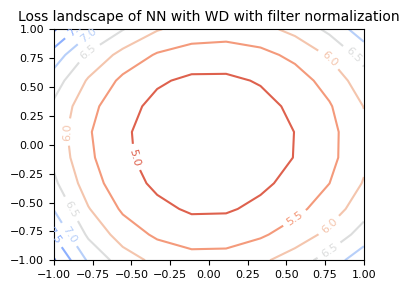

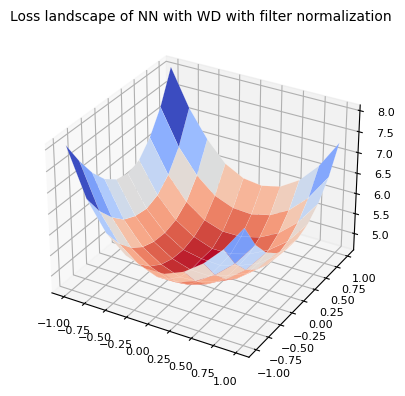

Loss landscape of NN without WD with filter normalization


100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


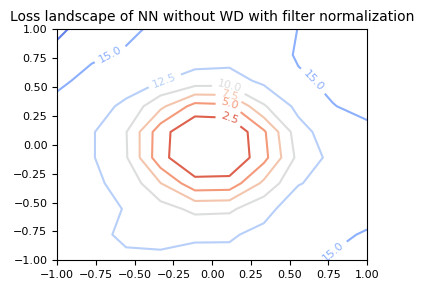

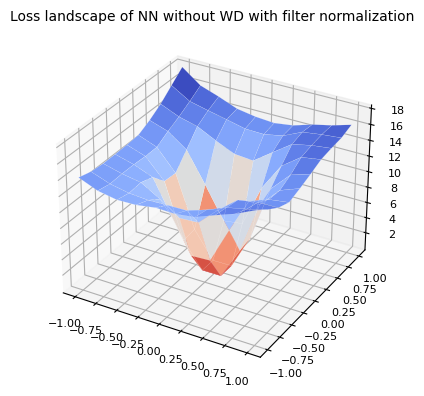

Loss landscape of NN with WD without filter normalization


100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


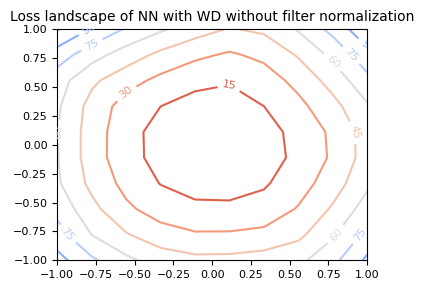

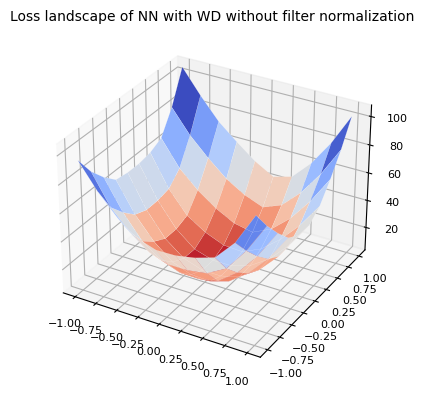

Loss landscape of NN without WD without filter normalization


100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


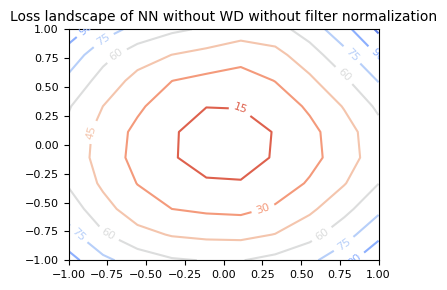

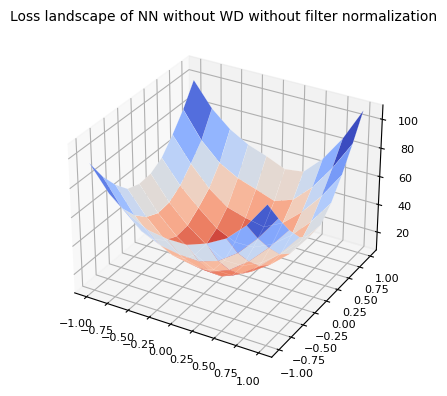

In [7]:
train_dataset = list(load_dataset(NUM_CLASSES, batch_dims, True, False, False))

# loss landscape visualization without filter normalization
for filter_normalized in [True, False]:
    for wd in [True, False]:
        
        with_wd = 'with' if wd else 'without'
        with_fn = 'with' if filter_normalized else 'without'
        title = f'Loss landscape of NN {with_wd} WD {with_fn} filter normalization'
        print(title)
        
        trainer = trainer_with_wd if wd else trainer_without_wd
        loss_landscape_visualization(trainer, train_dataset, filter_normalized=filter_normalized, title=title)